In [1]:
import d3rlpy
import d4rl
import gym
import h5py
import numpy as np
from d3rlpy.dataset import MDPDataset
from sklearn.model_selection import train_test_split
import gym
from gym.wrappers import TransformObservation
import encoders
import os

RuntimeError: Could not find supported GCC executable.

HINT: On OS X, install GCC 9.x with `brew install gcc@9`. or `port install gcc9`.

In [ ]:
print(gym.version.VERSION)

In [3]:
seed = 1
d3rlpy.seed(seed)
use_gpu = True
# prepare environment
#env = gym.make("InvertedPendulum-v2")
#eval_env = gym.make("InvertedPendulum-v2")
env = gym.make("Walker2d-v2")
eval_env = gym.make("Walker2d-v2")
env.reset(seed=seed)
eval_env.reset(seed=seed)

/home/yasin/.local/share/virtualenvs/symmetry-cs285-U_vq4NrE/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Walker2d-v2 is out of date. You should consider upgrading to version `v3` with the environment ID `Walker2d-v3`.
  logger.warn(


array([ 1.25450464e+00, -3.55840387e-03,  4.48649447e-03, -1.88168548e-03,
       -7.66735510e-04,  3.27702594e-03, -9.08008636e-04,  4.95936877e-04,
       -4.72440887e-03,  2.53513109e-03,  3.81433132e-04, -1.70268284e-03,
        2.88428703e-03, -1.96805171e-03, -4.65021105e-04, -3.65958303e-03,
       -9.68870136e-04])

## Get Dataset

In [4]:
def read_hdf5_to_dict(file_name):
    data = {}

    def recursive_read(group, prefix=''):
        for key in group.keys():
            if key not in ['observations', 'actions', 'terminals', 'rewards', 'timeouts']:
                continue
            item = group[key]
            if isinstance(item, h5py.Dataset):
                # This is a dataset
                data[prefix + key] = np.array(item)
            elif isinstance(item, h5py.Group):
                # This is a group, so recurse into it
                new_prefix = prefix + key + '/'
                recursive_read(item, new_prefix)

    with h5py.File(file_name, 'r') as f:
        recursive_read(f)

    return data
    
file_path = 'd3rlpy_data/walker2d_expert-v2.hdf5'  # Replace with the path to your HDF5 file
data_dict = read_hdf5_to_dict(file_path)

In [5]:
# Example transformation matrices
m = data_dict['observations'].shape[1]
n = data_dict['actions'].shape[1]
P_s = np.zeros((m,m))  # Replace with your P_s matrix
P_s
P_a = np.zeros((n,n))  # Replace with your P_a matrix

In [6]:
def create_permutation_matrix(size, source_indices, target_indices):
    """
    Create a permutation matrix of given size that permutes rows from source_indices to target_indices.

    :param size: Size of the square permutation matrix
    :param source_indices: List of indices to be permuted
    :param target_indices: List of target indices where source indices should be moved
    :return: Permutation matrix of size 'size x size'
    """
    if len(source_indices) != len(target_indices):
        raise ValueError("Source and target indices lists must be of the same length")

    # Create an identity matrix
    perm_matrix = np.identity(size)

    # Apply the permutations
    for src, tgt in zip(source_indices, target_indices):
        perm_matrix[[src, tgt]] = perm_matrix[[tgt, src]]

    return perm_matrix

In [7]:
m = data_dict['observations'].shape[1]
n = data_dict['actions'].shape[1]

P_s = create_permutation_matrix(m, [2, 3, 4, 11, 12, 13], [5, 6, 7, 14, 15, 16])
P_a = create_permutation_matrix(n, [0, 1, 2], [3, 4, 5])

In [8]:
P_s, P_a

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.

In [59]:
def create_train_merge_matrix(m, source_indices, target_indices):
    """
    Create two matrices that prepares the data to train with symmetry and merge afterwards

    :param m: Size of the state space
    :param source_indices: List of indices to be permuted
    :param target_indices: List of target indices where source indices should be moved
    :return: train_matrix: removes the rows with target indices from the data
    merge_matrix: takes input of size 2(m-len*(target_indices)) and merges them into 
    next observations data of size m by averaging the common parts and merging different parts
    """
    if len(source_indices) != len(target_indices):
        raise ValueError("Source and target indices lists must be of the same length")

    # Create an identity matrix
    train_matrix = np.identity(m)
    train_matrix = np.delete(train_matrix, target_indices, axis=0)

    t = m - len(target_indices) # size of new data
    merge_matrix = np.zeros((m, 2*t))
    reduced_idx=0
    for i in range(m):
        print(i, reduced_idx)
        if i not in source_indices and i not in target_indices:
            # common states, average
            merge_matrix[i, reduced_idx] = 0.5
            merge_matrix[i, t + reduced_idx] = 0.5
            reduced_idx += 1
        elif i in source_indices:
            permutation_idx = np.where(np.array(source_indices) == i)[0][0]
            target_i = target_indices[permutation_idx]
            print('permute: ', i, target_i)
            merge_matrix[i, reduced_idx] = 1
            merge_matrix[target_i, t + reduced_idx] = 1
            reduced_idx += 1

    return train_matrix, merge_matrix

In [60]:
create_train_merge_matrix(m, [2, 3, 4, 11, 12, 13], [5, 6, 7, 14, 15, 16])

0 0
1 1
2 2
permute:  2 5
3 3
permute:  3 6
4 4
permute:  4 7
5 5
6 5
7 5
8 5
9 6
10 7
11 8
permute:  11 14
12 9
permute:  12 15
13 10
permute:  13 16
14 11
15 11
16 11


(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0.]]),
 array([[0.5, 0. , 0. , 0. , 0. , 0. , 0.

In [65]:
def augment_data(data_dict, P_s, P_a):
    # Vectorized transformation
    transformed_observations = np.dot(data_dict['observations'], P_s.T)  # Transpose if necessary
    transformed_actions = np.dot(data_dict['actions'], P_a.T)            # Transpose if necessary
    
    data_dict['observations'] = np.concatenate((data_dict['observations'], transformed_observations), axis=0)
    data_dict['actions'] = np.concatenate((data_dict['actions'], transformed_actions), axis=0)
    data_dict['terminals'] = np.concatenate((data_dict['terminals'], data_dict['terminals']))
    data_dict['rewards'] = np.concatenate((data_dict['rewards'], data_dict['rewards']))
    data_dict['timeouts'] = np.concatenate((data_dict['timeouts'], data_dict['timeouts']))

In [66]:
augment_data(data_dict, P_s, P_a)

In [67]:
dataset = MDPDataset(data_dict['observations'], data_dict['actions'], data_dict['rewards'], np.logical_or(data_dict['terminals'], data_dict['timeouts']))
del data_dict

In [70]:
offset = 1000000
idx = 100
s = dataset.observations[idx]
s_transformed = dataset.observations[idx + offset]

In [71]:
def state_to_q(state):
    q_pos = np.zeros(9)
    q_vel = np.zeros(9)
    q_pos[1:9] = state[0:8]
    q_vel[0:9] = state[8:17]
    return q_pos, q_vel

In [31]:
Qpos0 = Qpos
Qvel0 = Qvel

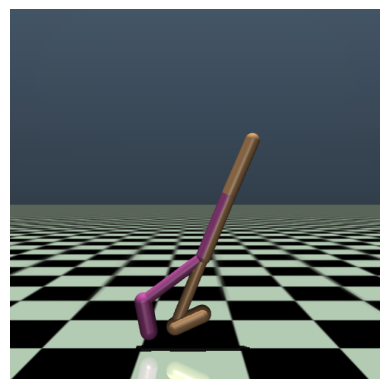

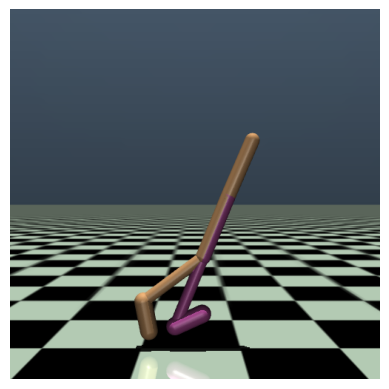

In [75]:
# Initialize the environment
env = gym.make('Walker2d-v2')
state = env.reset()

# Get qpos and qvel
Qpos = np.random.rand(9)+1
Qvel = np.random.rand(9)

"""Qpos = Qpos0
Qvel = Qvel0"""

Qpos, Qvel = state_to_q(s)

# Set the state according to original state
env.set_state(Qpos, Qvel)

# Render the environment as an RGB array
img = env.render(mode='rgb_array')

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

Ppos = create_permutation_matrix(9, [3,4,5], [6,7,8])
Pvel = create_permutation_matrix(9, [3,4,5], [6,7,8])

Qpos2 = Ppos@Qpos
Qvel2 = Pvel@Qvel

"""Qpos2 = Qpos
Qvel2 = Qvel

idx=2
Qpos2[idx] = Qpos[idx] + 1 
Qvel2 = Pvel@Qvel"""

Qpos2, Qvel2 = state_to_q(s_transformed)

# Set the state according to original state
env.set_state(Qpos2, Qvel2)

# Render the environment as an RGB array
img = env.render(mode='rgb_array')
# Close the environment
env.close()

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

## Training

In [31]:
train_episodes, test_episodes = train_test_split(dataset, random_state=seed, train_size=0.1)

In [32]:
#encoder_factory = encoders.SymmetryEncoderFactory(project=inverted_pendulum_project, projection_size=projection_size)
#dynamics = d3rlpy.dynamics.ProbabilisticEnsembleDynamics(learning_rate=1e-4, use_gpu=True, state_encoder_factory=encoder_factory)
dynamics = d3rlpy.dynamics.ProbabilisticEnsembleDynamics(learning_rate=1e-4, use_gpu=True) # Baseline

In [ ]:
# same as algorithms
dynamics.fit(train_episodes,
             eval_episodes=test_episodes,
             n_epochs=100,
             scorers={
                'observation_error': d3rlpy.metrics.scorer.dynamics_observation_prediction_error_scorer,
                'reward_error': d3rlpy.metrics.scorer.dynamics_reward_prediction_error_scorer,
                'variance': d3rlpy.metrics.scorer.dynamics_prediction_variance_scorer,
             },
            tensorboard_dir='tensorboard_logs/dynamics',
            experiment_name='SeparateStateAndRewardEncoders')

2023-11-14 21:29:08 [debug    ] RoundIterator is selected.
2023-11-14 21:29:08 [info     ] Directory is created at d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908
2023-11-14 21:29:08 [debug    ] Building models...
2023-11-14 21:29:08 [debug    ] Models have been built.
2023-11-14 21:29:08 [info     ] Parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/params.json params={'action_scaler': None, 'batch_size': 100, 'discrete_action': False, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_ensembles': 5, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False}, 'real_ratio': 1.0, 'reward_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'reward_scaler': None, 'scaler': None, 'state_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': Fal

Epoch 1/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:29:57 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=1 step=992 epoch=1 metrics={'time_sample_batch': 0.00025271119609955817, 'time_algorithm_update': 0.02303843056001971, 'loss': -39.001211083471595, 'time_step': 0.023374602919624697, 'observation_error': 43.4004609201577, 'reward_error': 0.016453990222475432, 'variance': 22.547224731700684} step=992
2023-11-14 21:29:57 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_992.pt


Epoch 2/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:30:41 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=2 step=1984 epoch=2 metrics={'time_sample_batch': 0.00023783887586285992, 'time_algorithm_update': 0.022105127332671996, 'loss': -61.47404948021135, 'time_step': 0.02241803249043803, 'observation_error': 45.788177242730626, 'reward_error': 0.01016925438169652, 'variance': 25.64507883825302} step=1984
2023-11-14 21:30:41 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_1984.pt


Epoch 3/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:31:26 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=3 step=2976 epoch=3 metrics={'time_sample_batch': 0.00024711436802341095, 'time_algorithm_update': 0.021937623620033264, 'loss': -67.79079784933597, 'time_step': 0.02225967232258089, 'observation_error': 44.49805901259089, 'reward_error': 0.006933039223354913, 'variance': 24.591408610806464} step=2976
2023-11-14 21:31:26 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_2976.pt


Epoch 4/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:32:11 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=4 step=3968 epoch=4 metrics={'time_sample_batch': 0.00025936600662046863, 'time_algorithm_update': 0.021747652801775163, 'loss': -74.69141447640234, 'time_step': 0.0220895299027043, 'observation_error': 45.85024042346825, 'reward_error': 0.005845018692515095, 'variance': 26.463211435627407} step=3968
2023-11-14 21:32:11 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_3968.pt


Epoch 5/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:32:56 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=5 step=4960 epoch=5 metrics={'time_sample_batch': 0.0002511559474852777, 'time_algorithm_update': 0.021507944070523786, 'loss': -78.57217763796929, 'time_step': 0.021839108918943712, 'observation_error': 44.76986706569223, 'reward_error': 0.0048291328347295, 'variance': 25.45745202042262} step=4960
2023-11-14 21:32:56 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_4960.pt


Epoch 6/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:33:40 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=6 step=5952 epoch=6 metrics={'time_sample_batch': 0.0002404439353173779, 'time_algorithm_update': 0.021496439172375585, 'loss': -81.94514847474713, 'time_step': 0.021814471771640163, 'observation_error': 45.26272444978763, 'reward_error': 0.004156605407183281, 'variance': 26.632990397714508} step=5952
2023-11-14 21:33:40 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_5952.pt


Epoch 7/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:34:24 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=7 step=6944 epoch=7 metrics={'time_sample_batch': 0.00024880108333403064, 'time_algorithm_update': 0.0214360517359549, 'loss': -81.92895012973777, 'time_step': 0.021762563576621395, 'observation_error': 43.26217115602332, 'reward_error': 0.0041001422333044515, 'variance': 24.713204239645535} step=6944
2023-11-14 21:34:24 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_6944.pt


Epoch 8/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:35:11 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=8 step=7936 epoch=8 metrics={'time_sample_batch': 0.0002664041615301563, 'time_algorithm_update': 0.022456519546047334, 'loss': -83.14716051566985, 'time_step': 0.022806797056428848, 'observation_error': 43.07792462208441, 'reward_error': 0.0034702222157408187, 'variance': 24.564442231557106} step=7936
2023-11-14 21:35:11 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_7936.pt


Epoch 9/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:35:58 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=9 step=8928 epoch=9 metrics={'time_sample_batch': 0.00028344291833139234, 'time_algorithm_update': 0.02430772348757713, 'loss': -84.99661736863274, 'time_step': 0.024677270122112765, 'observation_error': 42.61580233932553, 'reward_error': 0.0030587134146211063, 'variance': 24.469036133569613} step=8928
2023-11-14 21:35:58 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_8928.pt


Epoch 10/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:36:44 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=10 step=9920 epoch=10 metrics={'time_sample_batch': 0.00026531156993681384, 'time_algorithm_update': 0.023085130078177297, 'loss': -87.97647725574431, 'time_step': 0.023434124165965665, 'observation_error': 42.89843110032249, 'reward_error': 0.003304284340692829, 'variance': 24.960855157132677} step=9920
2023-11-14 21:36:44 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_9920.pt


Epoch 11/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:37:29 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=11 step=10912 epoch=11 metrics={'time_sample_batch': 0.00025957822799682617, 'time_algorithm_update': 0.022305217481428576, 'loss': -89.1849231448385, 'time_step': 0.022643088333068356, 'observation_error': 41.99172514934505, 'reward_error': 0.0028869631116271426, 'variance': 24.01629369482676} step=10912
2023-11-14 21:37:29 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_10912.pt


Epoch 12/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:38:15 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=12 step=11904 epoch=12 metrics={'time_sample_batch': 0.00025974262145257764, 'time_algorithm_update': 0.02295404456315502, 'loss': -88.98211520477649, 'time_step': 0.023297443745597717, 'observation_error': 41.164219686232656, 'reward_error': 0.002695837908053498, 'variance': 23.130759933456314} step=11904
2023-11-14 21:38:15 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_11904.pt


Epoch 13/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:38:59 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=13 step=12896 epoch=13 metrics={'time_sample_batch': 0.00023465002736737652, 'time_algorithm_update': 0.02098147931598848, 'loss': -90.67705409853689, 'time_step': 0.021295300174144008, 'observation_error': 41.83776258460376, 'reward_error': 0.0027422549499183557, 'variance': 24.328460015499857} step=12896
2023-11-14 21:38:59 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_12896.pt


Epoch 14/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:39:42 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=14 step=13888 epoch=14 metrics={'time_sample_batch': 0.00022601336240768433, 'time_algorithm_update': 0.020629445871999188, 'loss': -92.56963223795736, 'time_step': 0.020928800827072512, 'observation_error': 42.15852065521219, 'reward_error': 0.002913096507448536, 'variance': 24.86005408998516} step=13888
2023-11-14 21:39:42 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_13888.pt


Epoch 15/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:40:29 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=15 step=14880 epoch=15 metrics={'time_sample_batch': 0.00024989271356213477, 'time_algorithm_update': 0.02204003401340977, 'loss': -93.6434417270845, 'time_step': 0.022369569588092067, 'observation_error': 41.93543645186048, 'reward_error': 0.0026039604063509206, 'variance': 24.42482462204377} step=14880
2023-11-14 21:40:29 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_14880.pt


Epoch 16/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:41:17 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=16 step=15872 epoch=16 metrics={'time_sample_batch': 0.0003098323941230774, 'time_algorithm_update': 0.02524277832238905, 'loss': -93.78991958402818, 'time_step': 0.02564683989171059, 'observation_error': 41.795409739401705, 'reward_error': 0.002419652874858201, 'variance': 24.927843386674457} step=15872
2023-11-14 21:41:17 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_15872.pt


Epoch 17/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:42:03 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=17 step=16864 epoch=17 metrics={'time_sample_batch': 0.000273175056903593, 'time_algorithm_update': 0.022786877568691008, 'loss': -93.90226104158548, 'time_step': 0.023142130865204717, 'observation_error': 42.58333749451807, 'reward_error': 0.0025786850504204376, 'variance': 26.28943162711938} step=16864
2023-11-14 21:42:03 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_16864.pt


Epoch 18/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:42:48 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=18 step=17856 epoch=18 metrics={'time_sample_batch': 0.00024163867196729108, 'time_algorithm_update': 0.021488349283895185, 'loss': -95.17271502171793, 'time_step': 0.02180691135506476, 'observation_error': 42.16797164353208, 'reward_error': 0.0025507404056083383, 'variance': 25.509545483772225} step=17856
2023-11-14 21:42:48 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_17856.pt


Epoch 19/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:43:36 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=19 step=18848 epoch=19 metrics={'time_sample_batch': 0.00030480637665717834, 'time_algorithm_update': 0.02460837027718944, 'loss': -98.95077873526081, 'time_step': 0.025002616788110426, 'observation_error': 40.972890222735494, 'reward_error': 0.002486894492662727, 'variance': 24.237738938955335} step=18848
2023-11-14 21:43:36 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_18848.pt


Epoch 20/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:44:22 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=20 step=19840 epoch=20 metrics={'time_sample_batch': 0.00026812909110899896, 'time_algorithm_update': 0.022771664444477327, 'loss': -94.27305499199898, 'time_step': 0.023118425521158403, 'observation_error': 40.95337497183383, 'reward_error': 0.002705557852593208, 'variance': 24.24772035944753} step=19840
2023-11-14 21:44:22 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_19840.pt


Epoch 21/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:45:08 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=21 step=20832 epoch=21 metrics={'time_sample_batch': 0.0002763826520212235, 'time_algorithm_update': 0.02273425147418053, 'loss': -97.74281774124792, 'time_step': 0.023091109769959605, 'observation_error': 41.37032681062143, 'reward_error': 0.002336766256924645, 'variance': 25.375266975880464} step=20832
2023-11-14 21:45:08 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_20832.pt


Epoch 22/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:45:59 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=22 step=21824 epoch=22 metrics={'time_sample_batch': 0.0003300426948455072, 'time_algorithm_update': 0.027525604732574954, 'loss': -99.00634179288342, 'time_step': 0.0279609618648406, 'observation_error': 40.528152484457095, 'reward_error': 0.0023284596467886658, 'variance': 23.83657875245571} step=21824
2023-11-14 21:45:59 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_21824.pt


Epoch 23/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:46:45 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=23 step=22816 epoch=23 metrics={'time_sample_batch': 0.00026581196054335565, 'time_algorithm_update': 0.023043132357058987, 'loss': -100.39199947637897, 'time_step': 0.023386804086546743, 'observation_error': 41.64086826014276, 'reward_error': 0.0022192846746768506, 'variance': 25.795665669630235} step=22816
2023-11-14 21:46:45 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_22816.pt


Epoch 24/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:47:32 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=24 step=23808 epoch=24 metrics={'time_sample_batch': 0.0002552386253110824, 'time_algorithm_update': 0.022815760345228257, 'loss': -100.3950082808733, 'time_step': 0.0231401004618214, 'observation_error': 41.30472613246066, 'reward_error': 0.0023891321935949534, 'variance': 25.055457111589114} step=23808
2023-11-14 21:47:32 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_23808.pt


Epoch 25/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:48:17 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=25 step=24800 epoch=25 metrics={'time_sample_batch': 0.0002562879554687008, 'time_algorithm_update': 0.022922920363564647, 'loss': -101.34700237743316, 'time_step': 0.023250842767377055, 'observation_error': 41.37957689299919, 'reward_error': 0.002114602164799047, 'variance': 25.89095968440188} step=24800
2023-11-14 21:48:17 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_24800.pt


Epoch 26/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:49:01 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=26 step=25792 epoch=26 metrics={'time_sample_batch': 0.00022132141936209894, 'time_algorithm_update': 0.02034796942626276, 'loss': -99.75957201661602, 'time_step': 0.020632120630433484, 'observation_error': 40.49951053080313, 'reward_error': 0.0022608496439435626, 'variance': 24.61641502115753} step=25792
2023-11-14 21:49:01 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_25792.pt


Epoch 27/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:49:44 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=27 step=26784 epoch=27 metrics={'time_sample_batch': 0.0002217153387684976, 'time_algorithm_update': 0.020368682521004832, 'loss': -103.25199329468512, 'time_step': 0.020649811433207606, 'observation_error': 40.767635662356945, 'reward_error': 0.0023512277930743727, 'variance': 24.811147203328346} step=26784
2023-11-14 21:49:44 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_26784.pt


Epoch 28/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:50:28 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=28 step=27776 epoch=28 metrics={'time_sample_batch': 0.00021814963509959558, 'time_algorithm_update': 0.020303285891009916, 'loss': -103.07623204300481, 'time_step': 0.02058048281938799, 'observation_error': 40.843626867891274, 'reward_error': 0.0019835722101870595, 'variance': 26.543427697062626} step=27776
2023-11-14 21:50:28 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_27776.pt


Epoch 29/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:51:12 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=29 step=28768 epoch=29 metrics={'time_sample_batch': 0.00022131444946412118, 'time_algorithm_update': 0.02052841023091347, 'loss': -102.81762781546962, 'time_step': 0.020811570748206106, 'observation_error': 42.410448809120446, 'reward_error': 0.0021603070503728537, 'variance': 28.383515144651067} step=28768
2023-11-14 21:51:12 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_28768.pt


Epoch 30/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:51:55 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=30 step=29760 epoch=30 metrics={'time_sample_batch': 0.00021798379959598663, 'time_algorithm_update': 0.0203537666989911, 'loss': -103.67346763947317, 'time_step': 0.020631145806081833, 'observation_error': 41.17797161536329, 'reward_error': 0.0022017658460765817, 'variance': 26.128066270791955} step=29760
2023-11-14 21:51:55 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_29760.pt


Epoch 31/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:52:38 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=31 step=30752 epoch=31 metrics={'time_sample_batch': 0.00021858825798957578, 'time_algorithm_update': 0.020507997322467067, 'loss': -103.99628905423226, 'time_step': 0.020787276808292635, 'observation_error': 40.005391022744504, 'reward_error': 0.0021911779071549925, 'variance': 24.414681519349216} step=30752
2023-11-14 21:52:38 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_30752.pt


Epoch 32/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:53:22 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=32 step=31744 epoch=32 metrics={'time_sample_batch': 0.0002195400095755054, 'time_algorithm_update': 0.02040718303572747, 'loss': -103.22056813490006, 'time_step': 0.020686629078080578, 'observation_error': 40.24068992269282, 'reward_error': 0.0018547208247850053, 'variance': 24.942273260802956} step=31744
2023-11-14 21:53:22 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_31744.pt


Epoch 33/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:54:05 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=33 step=32736 epoch=33 metrics={'time_sample_batch': 0.00022269569097026703, 'time_algorithm_update': 0.02040674994068761, 'loss': -102.35619106600362, 'time_step': 0.02069824525425511, 'observation_error': 39.3652730968132, 'reward_error': 0.0018314836727813693, 'variance': 24.33370803732925} step=32736
2023-11-14 21:54:05 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_32736.pt


Epoch 34/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:55:03 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=34 step=33728 epoch=34 metrics={'time_sample_batch': 0.000269162078057566, 'time_algorithm_update': 0.02392301900732902, 'loss': -103.18242978448829, 'time_step': 0.02427211211573693, 'observation_error': 39.95029957345183, 'reward_error': 0.0019151870328291635, 'variance': 25.302233526497815} step=33728
2023-11-14 21:55:03 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_33728.pt


Epoch 35/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:55:51 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=35 step=34720 epoch=35 metrics={'time_sample_batch': 0.0002624815510165307, 'time_algorithm_update': 0.023349989325769486, 'loss': -106.75020314993397, 'time_step': 0.023681998012527343, 'observation_error': 40.47210139996094, 'reward_error': 0.0021214440271804494, 'variance': 26.084390711539985} step=34720
2023-11-14 21:55:51 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_34720.pt


Epoch 36/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:56:35 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=36 step=35712 epoch=36 metrics={'time_sample_batch': 0.00023390569033161286, 'time_algorithm_update': 0.02044042295986606, 'loss': -107.16143824881122, 'time_step': 0.020736081705939387, 'observation_error': 40.10994731719251, 'reward_error': 0.0023183664672054953, 'variance': 25.39150948857387} step=35712
2023-11-14 21:56:35 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_35712.pt


Epoch 37/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:57:25 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=37 step=36704 epoch=37 metrics={'time_sample_batch': 0.0002428569620655429, 'time_algorithm_update': 0.02135727314218398, 'loss': -107.61596527647588, 'time_step': 0.021667660003708254, 'observation_error': 40.40791113582923, 'reward_error': 0.001967071408989647, 'variance': 25.46167759077006} step=36704
2023-11-14 21:57:25 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_36704.pt


Epoch 38/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:58:10 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=38 step=37696 epoch=38 metrics={'time_sample_batch': 0.00024684662780454083, 'time_algorithm_update': 0.021893807476566683, 'loss': -108.488378416146, 'time_step': 0.022208732462698413, 'observation_error': 39.13262087383676, 'reward_error': 0.0018316774555864257, 'variance': 24.19942152471814} step=37696
2023-11-14 21:58:10 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_37696.pt


Epoch 39/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:58:52 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=39 step=38688 epoch=39 metrics={'time_sample_batch': 0.00021382421255111694, 'time_algorithm_update': 0.01885821694327939, 'loss': -106.60376462965242, 'time_step': 0.01912777005664764, 'observation_error': 38.33071319704798, 'reward_error': 0.0019952581948789556, 'variance': 23.01673078627149} step=38688
2023-11-14 21:58:52 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_38688.pt


Epoch 40/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 21:59:33 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=40 step=39680 epoch=40 metrics={'time_sample_batch': 0.00019344086608579083, 'time_algorithm_update': 0.01814709315376897, 'loss': -107.7993250460394, 'time_step': 0.018393561003669616, 'observation_error': 41.11835568550101, 'reward_error': 0.0019764574439874033, 'variance': 27.39079101153281} step=39680
2023-11-14 21:59:33 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_39680.pt


Epoch 41/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:00:14 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=41 step=40672 epoch=41 metrics={'time_sample_batch': 0.00021286308765411377, 'time_algorithm_update': 0.019012425215013565, 'loss': -110.33918173274687, 'time_step': 0.019282058602379214, 'observation_error': 38.99408004819767, 'reward_error': 0.0018122503208908615, 'variance': 24.806308610734014} step=40672
2023-11-14 22:00:14 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_40672.pt


Epoch 42/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:00:56 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=42 step=41664 epoch=42 metrics={'time_sample_batch': 0.00021945589011715305, 'time_algorithm_update': 0.0190674340532672, 'loss': -109.22304934070957, 'time_step': 0.019344699478918505, 'observation_error': 38.78171231985536, 'reward_error': 0.0017739937534031619, 'variance': 24.374703231138056} step=41664
2023-11-14 22:00:56 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_41664.pt


Epoch 43/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:01:37 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=43 step=42656 epoch=43 metrics={'time_sample_batch': 0.00019368625456287015, 'time_algorithm_update': 0.018154401692651933, 'loss': -107.55396937362609, 'time_step': 0.018399795457240072, 'observation_error': 39.006450051030164, 'reward_error': 0.0017959961485855267, 'variance': 25.66863426653352} step=42656
2023-11-14 22:01:37 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_42656.pt


Epoch 44/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:02:20 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=44 step=43648 epoch=44 metrics={'time_sample_batch': 0.00021460436044200775, 'time_algorithm_update': 0.019117812235509197, 'loss': -108.66581978336457, 'time_step': 0.019389017214698177, 'observation_error': 38.71302926638312, 'reward_error': 0.0019048271837094346, 'variance': 24.264881896960073} step=43648
2023-11-14 22:02:20 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_43648.pt


Epoch 45/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:03:00 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=45 step=44640 epoch=45 metrics={'time_sample_batch': 0.0001943346954161121, 'time_algorithm_update': 0.01786412707259578, 'loss': -110.76051847204086, 'time_step': 0.018109170179213246, 'observation_error': 38.41469187105036, 'reward_error': 0.001663616237261334, 'variance': 24.37981708735466} step=44640
2023-11-14 22:03:00 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_44640.pt


Epoch 46/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:03:41 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=46 step=45632 epoch=46 metrics={'time_sample_batch': 0.00020854679807539908, 'time_algorithm_update': 0.019048589612207106, 'loss': -109.88675142055557, 'time_step': 0.01931283406672939, 'observation_error': 38.16775321906707, 'reward_error': 0.0018342235573480155, 'variance': 23.75462758010692} step=45632
2023-11-14 22:03:41 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_45632.pt


Epoch 47/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:04:26 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=47 step=46624 epoch=47 metrics={'time_sample_batch': 0.0002185363442667069, 'time_algorithm_update': 0.018865100799068328, 'loss': -112.61130107987312, 'time_step': 0.019141610831983628, 'observation_error': 39.56128377585891, 'reward_error': 0.0016631651166954932, 'variance': 26.24804820339779} step=46624
2023-11-14 22:04:26 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_46624.pt


Epoch 48/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:05:09 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=48 step=47616 epoch=48 metrics={'time_sample_batch': 0.0001969539350078952, 'time_algorithm_update': 0.018059570462472977, 'loss': -111.22820127202618, 'time_step': 0.018310655749613238, 'observation_error': 39.603185066961196, 'reward_error': 0.001823142887401102, 'variance': 26.64928856794238} step=47616
2023-11-14 22:05:09 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_47616.pt


Epoch 49/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:05:47 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=49 step=48608 epoch=49 metrics={'time_sample_batch': 0.00020919764234173682, 'time_algorithm_update': 0.01810407494345019, 'loss': -113.41679551716774, 'time_step': 0.018370235879575054, 'observation_error': 40.48314896487527, 'reward_error': 0.0016413354758130101, 'variance': 29.065852925938433} step=48608
2023-11-14 22:05:47 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_48608.pt


Epoch 50/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:06:25 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=50 step=49600 epoch=50 metrics={'time_sample_batch': 0.00020621452600725235, 'time_algorithm_update': 0.0174677653178092, 'loss': -109.80841318734231, 'time_step': 0.01772642856644046, 'observation_error': 36.99368722667794, 'reward_error': 0.0016584835091889515, 'variance': 22.609018275165823} step=49600
2023-11-14 22:06:25 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_49600.pt


Epoch 51/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:07:02 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=51 step=50592 epoch=51 metrics={'time_sample_batch': 0.00020751140771373627, 'time_algorithm_update': 0.017283179346592195, 'loss': -111.68877245533851, 'time_step': 0.017542790741689743, 'observation_error': 38.71320994840614, 'reward_error': 0.0017013308427489562, 'variance': 25.176251265696948} step=50592
2023-11-14 22:07:02 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_50592.pt


Epoch 52/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:07:40 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=52 step=51584 epoch=52 metrics={'time_sample_batch': 0.00022366811190882037, 'time_algorithm_update': 0.017924174185722105, 'loss': -113.45851267537763, 'time_step': 0.01820304124586044, 'observation_error': 36.87612228983435, 'reward_error': 0.0015854151996763245, 'variance': 22.4529449817527} step=51584
2023-11-14 22:07:40 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_51584.pt


Epoch 53/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:08:18 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=53 step=52576 epoch=53 metrics={'time_sample_batch': 0.00021830537626820227, 'time_algorithm_update': 0.017879093366284526, 'loss': -113.55523976972026, 'time_step': 0.018151637527250474, 'observation_error': 38.33812176790171, 'reward_error': 0.0018567744481823563, 'variance': 26.486547245725923} step=52576
2023-11-14 22:08:18 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_52576.pt


Epoch 54/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:08:57 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=54 step=53568 epoch=54 metrics={'time_sample_batch': 0.0002077147364616394, 'time_algorithm_update': 0.017378417714949575, 'loss': -113.23960144913966, 'time_step': 0.01763951826480127, 'observation_error': 41.53607755088449, 'reward_error': 0.0018477300192789466, 'variance': 30.083630615836647} step=53568
2023-11-14 22:08:57 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_53568.pt


Epoch 55/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:09:36 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=55 step=54560 epoch=55 metrics={'time_sample_batch': 0.00020397911148686563, 'time_algorithm_update': 0.018058590831295136, 'loss': -114.08048531413078, 'time_step': 0.018316133128058527, 'observation_error': 39.84331979583058, 'reward_error': 0.0016361419824097122, 'variance': 27.34112649407433} step=54560
2023-11-14 22:09:36 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_54560.pt


Epoch 56/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:10:15 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=56 step=55552 epoch=56 metrics={'time_sample_batch': 0.0002127126339943178, 'time_algorithm_update': 0.019008983767801715, 'loss': -113.44075421267941, 'time_step': 0.01927908678208628, 'observation_error': 42.63745005816319, 'reward_error': 0.0016366664158433736, 'variance': 33.328670670412514} step=55552
2023-11-14 22:10:15 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_55552.pt


Epoch 57/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:10:56 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=57 step=56544 epoch=57 metrics={'time_sample_batch': 0.0002122016683701546, 'time_algorithm_update': 0.0192684379796828, 'loss': -113.7913044227227, 'time_step': 0.019540620186636524, 'observation_error': 37.990187674991056, 'reward_error': 0.0017436643777291334, 'variance': 24.267501646700502} step=56544
2023-11-14 22:10:56 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_56544.pt


Epoch 58/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:11:35 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=58 step=57536 epoch=58 metrics={'time_sample_batch': 0.000216518678972798, 'time_algorithm_update': 0.018294031341229717, 'loss': -115.66896873135721, 'time_step': 0.01856557568234782, 'observation_error': 37.82434813009965, 'reward_error': 0.0014746797585630535, 'variance': 25.628118286931514} step=57536
2023-11-14 22:11:35 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_57536.pt


Epoch 59/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:12:14 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=59 step=58528 epoch=59 metrics={'time_sample_batch': 0.00021621969438368274, 'time_algorithm_update': 0.01905235960598915, 'loss': -116.0586555359825, 'time_step': 0.019327858282673742, 'observation_error': 37.03371765774693, 'reward_error': 0.0016407932389039285, 'variance': 24.17410838385403} step=58528
2023-11-14 22:12:14 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_58528.pt


Epoch 60/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:12:54 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=60 step=59520 epoch=60 metrics={'time_sample_batch': 0.00021913743788196194, 'time_algorithm_update': 0.018892468944672617, 'loss': -117.71550580907252, 'time_step': 0.019169783399951075, 'observation_error': 39.53649477080144, 'reward_error': 0.0016242292707377112, 'variance': 29.565579181782006} step=59520
2023-11-14 22:12:54 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_59520.pt


Epoch 61/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:13:34 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=61 step=60512 epoch=61 metrics={'time_sample_batch': 0.00020392695742268716, 'time_algorithm_update': 0.018381863111449827, 'loss': -113.00968954207436, 'time_step': 0.018641427399650697, 'observation_error': 38.57816900839435, 'reward_error': 0.0015448526266042613, 'variance': 27.19495168708894} step=60512
2023-11-14 22:13:34 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_60512.pt


Epoch 62/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:14:13 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=62 step=61504 epoch=62 metrics={'time_sample_batch': 0.0002177110122096154, 'time_algorithm_update': 0.01925022755899737, 'loss': -116.50940464292803, 'time_step': 0.01952544503634976, 'observation_error': 37.497074535445456, 'reward_error': 0.0016086847136001987, 'variance': 24.06303283430636} step=61504
2023-11-14 22:14:13 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_61504.pt


Epoch 63/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:14:52 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=63 step=62496 epoch=63 metrics={'time_sample_batch': 0.00021024312703840195, 'time_algorithm_update': 0.018833332004085664, 'loss': -115.08355304454604, 'time_step': 0.019100686955836513, 'observation_error': 36.25185580723697, 'reward_error': 0.001609266571074768, 'variance': 23.12942517358687} step=62496
2023-11-14 22:14:52 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_62496.pt


Epoch 64/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:15:31 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=64 step=63488 epoch=64 metrics={'time_sample_batch': 0.00021291283830519644, 'time_algorithm_update': 0.017205494305779858, 'loss': -116.04517193763486, 'time_step': 0.017471130336484602, 'observation_error': 37.04040332483361, 'reward_error': 0.0015281640431185428, 'variance': 23.303445432057647} step=63488
2023-11-14 22:15:31 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_63488.pt


Epoch 65/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:16:09 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=65 step=64480 epoch=65 metrics={'time_sample_batch': 0.00021198632255677255, 'time_algorithm_update': 0.018774736552469192, 'loss': -117.09834356654075, 'time_step': 0.019044312017579234, 'observation_error': 36.79638306518546, 'reward_error': 0.0015797860461050234, 'variance': 23.131144828547903} step=64480
2023-11-14 22:16:09 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_64480.pt


Epoch 66/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:16:48 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=66 step=65472 epoch=66 metrics={'time_sample_batch': 0.0002180405201450471, 'time_algorithm_update': 0.018240995705127716, 'loss': -115.76672737540737, 'time_step': 0.018515558012070193, 'observation_error': 36.911223669033305, 'reward_error': 0.0015456615247780975, 'variance': 23.35593157334864} step=65472
2023-11-14 22:16:48 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_65472.pt


Epoch 67/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:17:27 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=67 step=66464 epoch=67 metrics={'time_sample_batch': 0.00020115510109932193, 'time_algorithm_update': 0.018112686853254994, 'loss': -116.43934631059247, 'time_step': 0.01836814058403815, 'observation_error': 38.49977924654926, 'reward_error': 0.0016296465123858408, 'variance': 27.94029291590101} step=66464
2023-11-14 22:17:27 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_66464.pt


Epoch 68/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:18:05 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=68 step=67456 epoch=68 metrics={'time_sample_batch': 0.00019852432512467908, 'time_algorithm_update': 0.01736025175740642, 'loss': -116.84793611687999, 'time_step': 0.01761094504787076, 'observation_error': 37.16449105882532, 'reward_error': 0.0014828540008225903, 'variance': 24.014342670019204} step=67456
2023-11-14 22:18:05 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_67456.pt


Epoch 69/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:18:44 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=69 step=68448 epoch=69 metrics={'time_sample_batch': 0.00021956861019134521, 'time_algorithm_update': 0.01915483921766281, 'loss': -118.46603348682964, 'time_step': 0.019431296375490004, 'observation_error': 36.26402218605329, 'reward_error': 0.0015882365995676646, 'variance': 22.84451089334137} step=68448
2023-11-14 22:18:44 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_68448.pt


Epoch 70/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:19:22 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=70 step=69440 epoch=70 metrics={'time_sample_batch': 0.00021511869084450507, 'time_algorithm_update': 0.017727076526611082, 'loss': -117.17253010888254, 'time_step': 0.01799732518772925, 'observation_error': 36.96504238780977, 'reward_error': 0.0015096694632174702, 'variance': 24.623054434926445} step=69440
2023-11-14 22:19:22 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_69440.pt


Epoch 71/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:20:01 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=71 step=70432 epoch=71 metrics={'time_sample_batch': 0.00020654619701447025, 'time_algorithm_update': 0.018277452117012392, 'loss': -119.03175296610401, 'time_step': 0.01853848224686038, 'observation_error': 36.57921372096204, 'reward_error': 0.0014954960207925097, 'variance': 23.471546386151182} step=70432
2023-11-14 22:20:01 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_70432.pt


Epoch 72/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:20:39 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=72 step=71424 epoch=72 metrics={'time_sample_batch': 0.000209367323306299, 'time_algorithm_update': 0.01819823874581245, 'loss': -117.36808730709937, 'time_step': 0.018464429243918386, 'observation_error': 35.91342064557411, 'reward_error': 0.0014837846382092252, 'variance': 22.252026457908617} step=71424
2023-11-14 22:20:39 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_71424.pt


Epoch 73/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:21:18 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=73 step=72416 epoch=73 metrics={'time_sample_batch': 0.00021400903501818256, 'time_algorithm_update': 0.01838476691515215, 'loss': -119.58374814256545, 'time_step': 0.018656277608486913, 'observation_error': 36.520435004820875, 'reward_error': 0.0015711096224505978, 'variance': 24.278758064373466} step=72416
2023-11-14 22:21:18 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_72416.pt


Epoch 74/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:21:56 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=74 step=73408 epoch=74 metrics={'time_sample_batch': 0.0002028180226202934, 'time_algorithm_update': 0.01769335664087726, 'loss': -119.75252240319406, 'time_step': 0.01794960229627548, 'observation_error': 36.18623993011162, 'reward_error': 0.0014835281865347983, 'variance': 24.11706635096643} step=73408
2023-11-14 22:21:56 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_73408.pt


Epoch 75/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:22:34 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=75 step=74400 epoch=75 metrics={'time_sample_batch': 0.00020751813727040445, 'time_algorithm_update': 0.017309702932834625, 'loss': -119.30591982987619, 'time_step': 0.017571922752165025, 'observation_error': 35.686394037564305, 'reward_error': 0.0015313426222538118, 'variance': 22.88213320868373} step=74400
2023-11-14 22:22:34 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_74400.pt


Epoch 76/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:23:13 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=76 step=75392 epoch=76 metrics={'time_sample_batch': 0.00021223483547087637, 'time_algorithm_update': 0.018227196749179594, 'loss': -119.44864637044168, 'time_step': 0.018495718798329754, 'observation_error': 35.73007203716967, 'reward_error': 0.001544535044616282, 'variance': 22.598925833235384} step=75392
2023-11-14 22:23:13 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_75392.pt


Epoch 77/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:23:51 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=77 step=76384 epoch=77 metrics={'time_sample_batch': 0.00020884241788618027, 'time_algorithm_update': 0.018371886303347927, 'loss': -120.85002750638992, 'time_step': 0.018636882545486573, 'observation_error': 36.05185562814974, 'reward_error': 0.0013466615131220339, 'variance': 23.009967707995045} step=76384
2023-11-14 22:23:51 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_76384.pt


Epoch 78/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:24:29 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=78 step=77376 epoch=78 metrics={'time_sample_batch': 0.00019609255175436697, 'time_algorithm_update': 0.017167735243997267, 'loss': -117.87678377859054, 'time_step': 0.017416208261443723, 'observation_error': 37.6569688504601, 'reward_error': 0.0015410046410569407, 'variance': 25.428665489621757} step=77376
2023-11-14 22:24:29 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_77376.pt


Epoch 79/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:25:07 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=79 step=78368 epoch=79 metrics={'time_sample_batch': 0.00021331372760957288, 'time_algorithm_update': 0.018128926234860576, 'loss': -119.32719502141398, 'time_step': 0.018400826761799473, 'observation_error': 39.734670748040394, 'reward_error': 0.0015801496414799229, 'variance': 28.937803908651272} step=78368
2023-11-14 22:25:07 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_78368.pt


Epoch 80/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:25:46 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=80 step=79360 epoch=80 metrics={'time_sample_batch': 0.0002100035067527525, 'time_algorithm_update': 0.01846821726329865, 'loss': -121.66909744566486, 'time_step': 0.018732790985415058, 'observation_error': 35.99262478673163, 'reward_error': 0.0014953553591063409, 'variance': 22.901676471465496} step=79360
2023-11-14 22:25:46 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_79360.pt


Epoch 81/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:26:24 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=81 step=80352 epoch=81 metrics={'time_sample_batch': 0.00021601828836625623, 'time_algorithm_update': 0.017863184694320924, 'loss': -119.27312592537173, 'time_step': 0.018136550582224322, 'observation_error': 35.643048222350984, 'reward_error': 0.0014808093558043565, 'variance': 22.71184120781415} step=80352
2023-11-14 22:26:24 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_80352.pt


Epoch 82/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:27:02 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=82 step=81344 epoch=82 metrics={'time_sample_batch': 0.00019964095084897934, 'time_algorithm_update': 0.017135287725156354, 'loss': -121.85197000541994, 'time_step': 0.01738592405473032, 'observation_error': 36.251743379652844, 'reward_error': 0.0015257108662048568, 'variance': 23.794174283349847} step=81344
2023-11-14 22:27:02 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_81344.pt


Epoch 83/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:27:40 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=83 step=82336 epoch=83 metrics={'time_sample_batch': 0.00021282823816422494, 'time_algorithm_update': 0.018127587533766223, 'loss': -122.457793653492, 'time_step': 0.01839775664191092, 'observation_error': 35.28444249558059, 'reward_error': 0.0014994260085417627, 'variance': 22.322580407660105} step=82336
2023-11-14 22:27:40 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_82336.pt


Epoch 84/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:28:18 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=84 step=83328 epoch=84 metrics={'time_sample_batch': 0.00021228891226553147, 'time_algorithm_update': 0.018020485197344133, 'loss': -121.57191812511414, 'time_step': 0.01828884405474509, 'observation_error': 36.350198423881466, 'reward_error': 0.0014646192543808527, 'variance': 23.889276711161102} step=83328
2023-11-14 22:28:18 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_83328.pt


Epoch 85/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:28:56 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=85 step=84320 epoch=85 metrics={'time_sample_batch': 0.0002128186245118418, 'time_algorithm_update': 0.017265041749323567, 'loss': -120.80127926411167, 'time_step': 0.017531698749911402, 'observation_error': 35.201035690945595, 'reward_error': 0.0013227470969329217, 'variance': 22.016826908635398} step=84320
2023-11-14 22:28:57 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_84320.pt


Epoch 86/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:29:34 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=86 step=85312 epoch=86 metrics={'time_sample_batch': 0.00020513611455117502, 'time_algorithm_update': 0.01733388247028474, 'loss': -121.67548700734493, 'time_step': 0.017590780652338458, 'observation_error': 38.04285046044014, 'reward_error': 0.00126588446423032, 'variance': 26.96343166228599} step=85312
2023-11-14 22:29:34 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_85312.pt


Epoch 87/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:30:13 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=87 step=86304 epoch=87 metrics={'time_sample_batch': 0.0002155681290934163, 'time_algorithm_update': 0.018375592606682933, 'loss': -123.3352538683722, 'time_step': 0.018644928211166013, 'observation_error': 37.6092634193231, 'reward_error': 0.0013337051362183687, 'variance': 26.264503023769755} step=86304
2023-11-14 22:30:13 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_86304.pt


Epoch 88/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:30:51 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=88 step=87296 epoch=88 metrics={'time_sample_batch': 0.00021018688717196063, 'time_algorithm_update': 0.018198956645304156, 'loss': -121.59055316159802, 'time_step': 0.018466454840475512, 'observation_error': 35.473176814477384, 'reward_error': 0.0013598115789775166, 'variance': 23.556060815655226} step=87296
2023-11-14 22:30:51 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_87296.pt


Epoch 89/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:31:29 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=89 step=88288 epoch=89 metrics={'time_sample_batch': 0.00020276658958004367, 'time_algorithm_update': 0.017147245666673108, 'loss': -122.25667582404229, 'time_step': 0.01740193655413966, 'observation_error': 34.81846553151427, 'reward_error': 0.0014092886271648499, 'variance': 21.992486813666325} step=88288
2023-11-14 22:31:29 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_88288.pt


Epoch 90/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:32:07 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=90 step=89280 epoch=90 metrics={'time_sample_batch': 0.00019832171740070465, 'time_algorithm_update': 0.01734099224690468, 'loss': -122.34646393791321, 'time_step': 0.017590357170950983, 'observation_error': 34.85427976290808, 'reward_error': 0.001377285862303592, 'variance': 21.784293158612087} step=89280
2023-11-14 22:32:07 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_89280.pt


Epoch 91/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:32:44 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=91 step=90272 epoch=91 metrics={'time_sample_batch': 0.0002084718115868107, 'time_algorithm_update': 0.017785097081815044, 'loss': -124.49954896396206, 'time_step': 0.01804753441003061, 'observation_error': 35.605072590837004, 'reward_error': 0.0014298977624717733, 'variance': 23.31604779548327} step=90272
2023-11-14 22:32:44 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_90272.pt


Epoch 92/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:33:23 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=92 step=91264 epoch=92 metrics={'time_sample_batch': 0.0002092586890343697, 'time_algorithm_update': 0.01826858832951515, 'loss': -121.13986396597278, 'time_step': 0.018534484649858168, 'observation_error': 35.06438123908293, 'reward_error': 0.0013745811880783686, 'variance': 22.80093299330877} step=91264
2023-11-14 22:33:23 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_91264.pt


Epoch 93/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:34:01 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=93 step=92256 epoch=93 metrics={'time_sample_batch': 0.00020883857242522702, 'time_algorithm_update': 0.01720280248311258, 'loss': -123.2798170351213, 'time_step': 0.017466169211172288, 'observation_error': 35.84941734055401, 'reward_error': 0.001323470493464907, 'variance': 23.187874401015208} step=92256
2023-11-14 22:34:01 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_92256.pt


Epoch 94/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:34:39 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=94 step=93248 epoch=94 metrics={'time_sample_batch': 0.00021813377257316342, 'time_algorithm_update': 0.018156343890774633, 'loss': -123.97668982321217, 'time_step': 0.01843202955299808, 'observation_error': 35.44482044196597, 'reward_error': 0.001343021424162882, 'variance': 22.823314460994535} step=93248
2023-11-14 22:34:39 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_93248.pt


Epoch 95/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:35:17 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=95 step=94240 epoch=95 metrics={'time_sample_batch': 0.00021311977217274328, 'time_algorithm_update': 0.018011697598042026, 'loss': -124.4631887751241, 'time_step': 0.018282226977809783, 'observation_error': 35.299441778847964, 'reward_error': 0.0013711640487650604, 'variance': 23.319252534989385} step=94240
2023-11-14 22:35:17 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_94240.pt


Epoch 96/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:35:56 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=96 step=95232 epoch=96 metrics={'time_sample_batch': 0.00022161679883157053, 'time_algorithm_update': 0.018271324615324696, 'loss': -122.51118320995762, 'time_step': 0.01855109752185883, 'observation_error': 34.95583406433821, 'reward_error': 0.001415578948081487, 'variance': 22.298285737071897} step=95232
2023-11-14 22:35:56 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_95232.pt


Epoch 97/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:36:33 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=97 step=96224 epoch=97 metrics={'time_sample_batch': 0.00020459150114367084, 'time_algorithm_update': 0.017256302698965994, 'loss': -124.67133453296077, 'time_step': 0.017513685168758515, 'observation_error': 34.896655733455475, 'reward_error': 0.001288039453963522, 'variance': 22.379860432766048} step=96224
2023-11-14 22:36:33 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_96224.pt


Epoch 98/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:37:11 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=98 step=97216 epoch=98 metrics={'time_sample_batch': 0.00021092497533367526, 'time_algorithm_update': 0.01790240599263099, 'loss': -125.14057612226856, 'time_step': 0.018171135215990005, 'observation_error': 34.45343410092868, 'reward_error': 0.001325730130646736, 'variance': 22.157576461240684} step=97216
2023-11-14 22:37:11 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_97216.pt


Epoch 99/100:   0%|          | 0/992 [00:00<?, ?it/s]

2023-11-14 22:37:50 [info     ] SeparateStateAndRewardEncoders_20231114212908: epoch=99 step=98208 epoch=99 metrics={'time_sample_batch': 0.00020923080944245862, 'time_algorithm_update': 0.018125137975139004, 'loss': -124.2604928420436, 'time_step': 0.018391027806266662, 'observation_error': 35.199419645193714, 'reward_error': 0.001197132637240125, 'variance': 23.095723561930722} step=98208
2023-11-14 22:37:50 [info     ] Model parameters are saved to d3rlpy_logs/SeparateStateAndRewardEncoders_20231114212908/model_98208.pt


Epoch 100/100:   0%|          | 0/992 [00:00<?, ?it/s]